In [210]:
# Mount your google drive. This will launch a pop-up window for authentication.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
# Adjust this to your directory

# Vincent
%cd "/content/drive/My Drive/es-143-assignments/Project/"

/content/drive/My Drive/es-143-assignments/Project


In [212]:
%pip install pupil-apriltags

In [213]:
# Import any required libraries here
import cv2                   # OpenCV
import numpy as np                       # numpy
import scipy.interpolate  # interpolation
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [370]:
#@title helper functions: `in2hom()`, `hom2in()`, `normalizing_transform()`

def in2hom(X):
    """
    Convert from inhomogeneous to homogeneous coordinates

    Args:
      X  - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      Xh - Nx(D+1) numpy array with an appended column of ones
    """

    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(Xh):
    """
    Convert from homogeneous to inhomogeneous coordinates

    Args:
      Xh  - Nx(D+1) numpy array, tyically with D=2 (rows (x,y,w)) or D=3 (rows (x,y,z,w))

    Returns:
      X - NxD numpy array with the first D columns divided by column (D+1)
    """

    return Xh[:, :Xh.shape[1] - 1] / Xh[:, Xh.shape[1] - 1][:, np.newaxis]

def normalizing_transform(X):
    """
    Compute a (Dx1)x(Dx1) normalizing transformation from N points in D dimensions

    Args:
      X - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      T - a (D+1)x(D+1) matrix that normalizes the points to be centered at their
          centroid, with average distance equal to sqrt(D)
    """

    # dimension of datapoints
    D = X.shape[1]

    # Compute centroid
    centroid = X.mean(axis=0, keepdims=True)

    # Compute the denominator of scale factor s
    denom = np.mean(np.sqrt(np.sum((X - centroid) ** 2, axis=1)))

    # Compute s, tx, ty
    s = np.sqrt(D) / denom
    t = -s * centroid[0, :]
    t = np.concatenate((t,np.array([1])))

    # return matrix T
    return np.concatenate((s*np.eye(D+1,D+1)[:,0:D], np.expand_dims(t,1)),axis=1)


#Calibrate Camera

In [215]:
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [216]:
#@title Helper function: `detect_aprilboard()`
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    """
    Detects April tags in a grayscale image.

    Usage: imgpoints, objpoints, tag_ids = detect_aprilboard(img, board, AT_detector)

    Input:
        image -- grayscale image
        board -- at_coarseboard or at_fineboard (list of dictionaries)
        AT_detector -- AprilTag Detector parameters

    Returns:
        imgpoints -- Nx2 numpy array of (x,y) image coords
        objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
        tag_ids -- Nx1 list of tag IDs
    """

    imgpoints=[]
    objpoints=[]
    tagIDs=[]

    # detect april tags
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))

        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))

            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])

            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))

            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

In [217]:
def calibrate_camera():
  # detect fiducials
  N = 70 # only use images with at least N detected objects for calibration
  total_valid = 0

  # Edit this line to point to the collection of input calibration image
  CALIBFILES = './data/playroom_lowres_images/*.JPG'

  # Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
  BOARD = at_fineboard
  #BOARD = at_coarseboard

  ###### BEGIN CALIBRATION SCRIPT

  # exit if no images are found or if BOARD is unrecognized
  images = glob.glob(CALIBFILES)
  assert images, "no calibration images matching: " + CALIBFILES
  assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

  # else continue
  print("{} images:".format(len(images)))

  # initialize 3D object points and 2D image points
  calObjPoints = []
  calImgPoints = []

  # loop through the images
  for count,fname in enumerate(images):

      # read image and convert to grayscale if necessary
      orig = cv2.imread(fname)
      if len(orig.shape) == 3:
          img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
      else:
          img = orig

      # detect apriltags and report number of detections
      imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
      print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

      # append detections if some are found
      if len(imgpoints) >= N and len(objpoints) >= N:
          total_valid += 1

          # append points detected in all images, (there is only one image now)
          calObjPoints.append(objpoints.astype('float32'))
          calImgPoints.append(imgpoints.astype('float32'))

  # calibrate the camera
  reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
      calObjPoints,
      calImgPoints,
      img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
      None,         # no initial guess for the remaining entries of calMatrix
      None,         # initial guesses for distortion coefficients are all 0
      flags = None) # default contstraints (see documentation)

  return reprojerr, calMatrix, distCoeffs

In [218]:
reprojerr, calMatrix, distCoeffs = calibrate_camera()

24 images:
0 ./data/playroom_lowres_images/playroom_es143_small_00016.JPG: 45 imgpts, 45 objpts
1 ./data/playroom_lowres_images/playroom_es143_small_00012.JPG: 28 imgpts, 28 objpts
2 ./data/playroom_lowres_images/playroom_es143_small_00013.JPG: 9 imgpts, 9 objpts
3 ./data/playroom_lowres_images/playroom_es143_small_00007.JPG: 71 imgpts, 71 objpts
4 ./data/playroom_lowres_images/playroom_es143_small_00006.JPG: 66 imgpts, 66 objpts
5 ./data/playroom_lowres_images/playroom_es143_small_00005.JPG: 67 imgpts, 67 objpts
6 ./data/playroom_lowres_images/playroom_es143_small_00010.JPG: 70 imgpts, 70 objpts
7 ./data/playroom_lowres_images/playroom_es143_small_00011.JPG: 51 imgpts, 51 objpts
8 ./data/playroom_lowres_images/playroom_es143_small_00004.JPG: 47 imgpts, 47 objpts
9 ./data/playroom_lowres_images/playroom_es143_small_00019.JPG: 74 imgpts, 74 objpts
10 ./data/playroom_lowres_images/playroom_es143_small_00015.JPG: 25 imgpts, 25 objpts
11 ./data/playroom_lowres_images/playroom_es143_small_0

#Detect Keypoints

In [219]:
# Load two images and convert to grayscale
im1 = cv2.cvtColor(cv2.imread('./data/playroom1.jpg'), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread('./data/playroom2.jpg'), cv2.COLOR_BGR2RGB)

In [220]:
sift = cv2.SIFT_create()

def detectKeypoints(im):
    # Use the detectAndCompute method of this SIFT object to
    #  detect SIFT keypoints and compute descriptor for each one
    keypoints, descriptors = sift.detectAndCompute(im, None)

    return keypoints, descriptors

In [221]:
keypoints1, descriptors1 = detectKeypoints(im1)
keypoints2, descriptors2 = detectKeypoints(im2)

In [222]:
def displayKeypoints(keypoints, descriptors, im):
    # Create new images that include visualizations of the detected interest points
    # Note: Due to a quirk in openCV, the third argument (which the documentation
    #       says should be the output image) is ignored so can be set to None.
    imKeypoints=cv2.drawKeypoints(im,
                                  keypoints,
                                  None,
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(imKeypoints)
    plt.axis('off')
    plt.show()

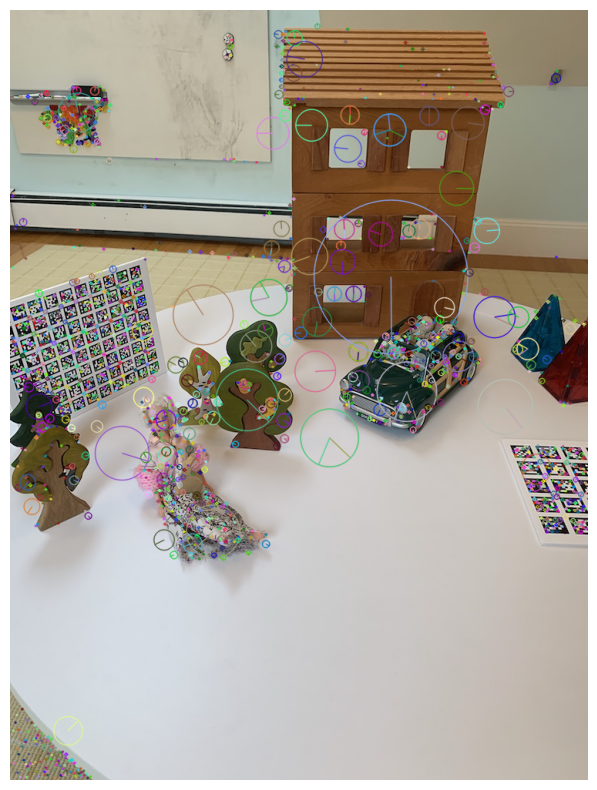

In [223]:
displayKeypoints(keypoints1, descriptors1, im1)

In [224]:
def matchKeypoints(keypoints1, keypoints2, descriptors1, descriptors2, percentage):
    """
    Find interest-point matches between two lists of interest point descriptors

    Args:
      keypoints1 - keypoints from sift.detectAndCompute() applied to Image 1
      keypoints2 - keypoints from sift.detectAndCompute() applied to Image 2
      descriptors1 - descriptors from sift.detectAndCompute() applied to Image 1
      descriptors2 - descriptors from sift.detectAndCompute() applied to Image 2
      percentage - number between 0 and 1

    Returns
      matches - list of Dmatch objects, which each have the following atrributes:
                DMatch.distance - Distance between descriptors. Lower is better.
                DMatch.trainIdx - Index of descriptor in "train" descriptors (descriptors1)
                DMatch.queryIdx - Index of descriptor in "query" descriptors (descriptors2)
                DMatch.imgIdx   - Index of the train image (useful when working with a large set of images; can be ignored here)
      X1 - Nx2 numpy array of points (x,y) from Image 1
      X1 - Nx2 numpy array of points (x,y) from Image 2
    """

    # Create a "brute force" matcher object using the L2 norm,
    #  and using "cross check" to only keep symmetric matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Use the match method of this matcher object to match
    #   descriptors between images
    matches12 = bf.match(descriptors1, descriptors2)
    num_matches12 = len(matches12)

    # TO DO: modify this line of code to find and return the
    #   (percentage * num_matches12) subset of matches that have
    #   the smallest distance between them

    goodmatches12 = sorted(matches12, key = lambda x:x.distance)[:int(percentage * num_matches12)]

    # for convenience, extract and return pixel coordinates of the good matches
    X1 = np.array([keypoints1[match.queryIdx].pt for match in matches12])
    X2 = np.array([keypoints2[match.trainIdx].pt for match in matches12])

    return goodmatches12, X1, X2

In [347]:
GOOD_MATCH_PERCENTAGE = 0.1
goodmatches, X1, X2 = matchKeypoints(keypoints1, keypoints2, descriptors1, descriptors2, GOOD_MATCH_PERCENTAGE)

In [348]:
def displayMatches(im1, keypoints1, im2, keypoints2, matches):
    # create an image that shows the matches
    im_matches = cv2.drawMatches(im1,
                                keypoints1,
                                im2,
                                keypoints2,
                                matches,
                                None)

    # display the image in figure
    fig,ax = plt.subplots(figsize=(20,15))
    ax.imshow(im_matches)
    ax.axis('off')
    plt.show()

In [349]:
displayMatches(im1, keypoints1, im2, keypoints2, goodmatches)

Output hidden; open in https://colab.research.google.com to view.

#Essential Matrix

In [350]:
E, mask = cv2.findEssentialMat(X1, X2, calMatrix, method=cv2.RANSAC)

In [351]:
R1, R2, t = cv2.decomposeEssentialMat(E)

# Triangulation

In [352]:
P1 = calMatrix @ np.hstack((np.eye(3), np.zeros((3, 1))))

P2 = calMatrix @ np.hstack((R2, t))

In [353]:
point_cloud = cv2.triangulatePoints(P1, P2, X1.T, X2.T)

In [372]:
points = hom2in(point_cloud.T)

In [371]:
temp = P2 @ point_cloud
temp = hom2in(temp.T)

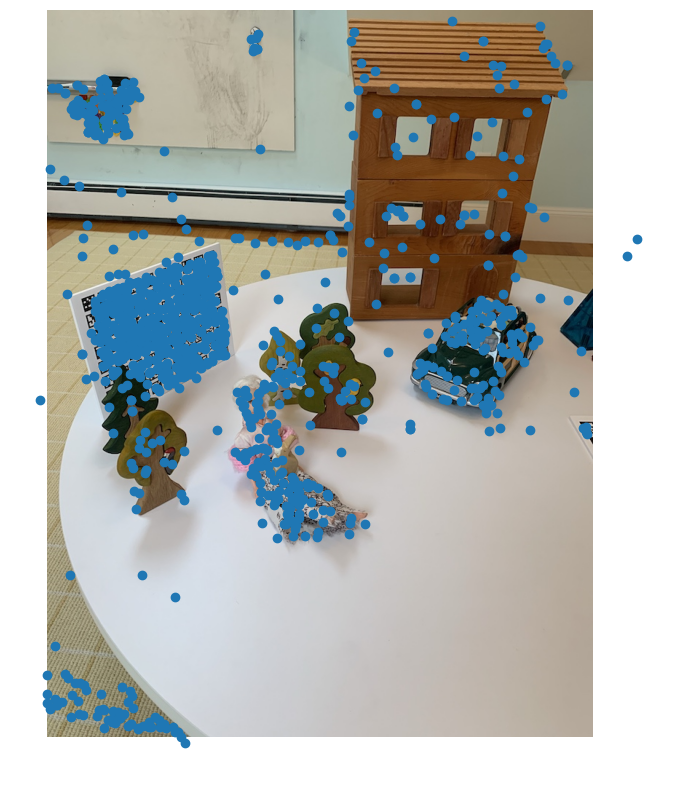

In [373]:
plt.imshow(im2)
plt.scatter(temp[:,0], temp[:,1])
plt.axis('off')
plt.show()

In [290]:
import plotly.graph_objects as go

In [291]:
def visualizeObjectPoints(points):
  x = points[:, 0]
  y = points[:, 1]
  z = points[:, 2]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    marker=dict(size=2))])
  fig.update_layout(scene=dict(
      xaxis=dict(range=[-20, 30]),
      yaxis=dict(range=[-20, 20]),
      zaxis=dict(range=[-200, 200])
  ))

  fig.show()

In [292]:
visualizeObjectPoints(points)